# CSE 482 Final Project - Part 2

### Josiah Hill, Michael Guel, Zachary Gage, John Foss, Peter Imoukhuede

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Project Definition

The primary objective of our project is to predict scoring for college football teams based on other team statistics like yards and first downs. Teams that outscore our predictions might be seen as "lucky" while teams that underperform might be considered "unlucky". Identifying games with high "luck" would provide us a subset of data for a future project that could analyze what "luck" really represents.

## Proposed Solution

The site CollegeFootballData.com provides a large amount of historic data on college football games. For our purposes, we have extracted data on every game played by a power-5 team over the last seven years, excluding 2020. Power-5 teams are teams from the ACC, SEC, Big 10, Big 12, and PAC 12, which are considered the premier conferences in college football. We only include these teams because they generally operate with a similar level of financial resources and have a more equal level of player performance in comparison to other conferences. We also exclude the year 2020 because we don't believe that the data from that year will follow the same trends as other years due to COVID-related complications.  

Our training data will consist of the data from 2017-19, 2021, and 2022. Given this data, we will identify and remove statistics that correlate too strongly with scoring (like touchdowns). We will use EDA to understand the distribution of our various features and potentially identify other features to exclude. Then we will compare various modeling techniques, such as linear regression, random forest, and xgboost, to identify the highest performing technique. Then we can perform a grid search to optimize the hyperparameters and finalize our model. We can then apply our model to our test data (2023) and visualize the results to see how luck is distributed across teams.

## Pre-Processing + Feature Selection

In [2]:
# Import data
game_data = pd.read_csv("All_Games.csv")
game_data = game_data.drop_duplicates()

In [3]:
game_data

,Game Id,School,Conference,HomeAway,Points,Stat Category,Stat
0,400937451,Syracuse,ACC,home,50,rushingTDs,3
1,400937451,Syracuse,ACC,home,50,puntReturnYards,7
2,400937451,Syracuse,ACC,home,50,puntReturnTDs,0
3,400937451,Syracuse,ACC,home,50,puntReturns,5
4,400937451,Syracuse,ACC,home,50,passingTDs,3
...,...,...,...,...,...,...,...
175644,401520184,Kent State,Mid-American,away,6,netPassingYards,174
175645,401520184,Kent State,Mid-American,away,6,totalYards,200
175646,401520184,Kent State,Mid-American,away,6,fourthDownEff,0-1
175647,401520184,Kent State,Mid-American,away,6,thirdDownEff,4-12


In [4]:
# Pivot the dataframe so that each stat category is a column
pivot_df = game_data.pivot_table(index=['Game Id', 'School'], columns='Stat Category', values='Stat', aggfunc='sum').reset_index()

# Merge the pivoted dataframe with the original dataframe
game_data_pivot = pd.merge(game_data[['Game Id', 'School', 'Conference', 'HomeAway', 'Points']].drop_duplicates(),
                     pivot_df, on=['Game Id', 'School'], how='left')

In [5]:
game_data_pivot

,Game Id,School,Conference,HomeAway,Points,completionAttempts,defensiveTDs,firstDowns,fourthDownEff,fumblesLost,...,sacks,tackles,tacklesForLoss,thirdDownEff,totalFumbles,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt
0,400937451,Syracuse,ACC,home,50,37-52,0,34,1-1,2,...,1,37,6,11-19,2,4-28,586,2,8.3,3.8
1,400937451,Central Connecticut,NEC,away,7,12-27,0,8,1-1,1,...,0,61,3,1-15,2,8-68,167,1,4.2,1.8
2,400937449,Bethune-Cookman,MEAC,away,13,25-39,0,20,2-2,1,...,0,39,2,8-17,1,13-96,350,2,5.9,4.0
3,400937449,Miami,ACC,home,41,18-31,0,28,0-0,0,...,1,44,7,4-8,1,8-83,555,0,7.5,9.5
4,400937450,Pittsburgh,ACC,home,28,17-24,0,24,3-3,1,...,1,36,4,9-16,1,0-0,348,1,5.8,3.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5145,401520191,Ball State,Mid-American,away,3,18-37,0,13,1-2,0,...,1,39,3,4-15,1,3-27,224,3,4.0,2.8
5146,401520214,Ole Miss,SEC,away,37,18-28,0,18,3-3,0,...,4,54,6,1-13,0,5-51,363,1,9.8,2.5
5147,401520214,Tulane,American Athletic,home,20,15-37,0,18,2-5,1,...,4,43,8,9-22,2,2-10,342,2,6.2,2.5
5148,401520184,Arkansas,SEC,home,28,13-19,1,19,1-2,0,...,7,21,11,9-14,NaN,4-34,308,0,7.2,3.8


In [6]:
# Drop mid-major teams
p5 = ['ACC', 'SEC', 'Big Ten', 'Big 12', 'Pac-12']
game_data_pivot = game_data_pivot[game_data_pivot['Conference'].isin(p5)]
game_data_pivot = game_data_pivot.reset_index(drop=True)

In [7]:
game_data_pivot

,Game Id,School,Conference,HomeAway,Points,completionAttempts,defensiveTDs,firstDowns,fourthDownEff,fumblesLost,...,sacks,tackles,tacklesForLoss,thirdDownEff,totalFumbles,totalPenaltiesYards,totalYards,turnovers,yardsPerPass,yardsPerRushAttempt
0,400937451,Syracuse,ACC,home,50,37-52,0,34,1-1,2,...,1,37,6,11-19,2,4-28,586,2,8.3,3.8
1,400937449,Miami,ACC,home,41,18-31,0,28,0-0,0,...,1,44,7,4-8,1,8-83,555,0,7.5,9.5
2,400937450,Pittsburgh,ACC,home,28,17-24,0,24,3-3,1,...,1,36,4,9-16,1,0-0,348,1,5.8,3.9
3,400937452,Virginia,ACC,home,28,27-40,0,19,2-4,0,...,2,29,3,9-18,2,3-15,354,0,6.6,2.9
4,400937448,Duke,ACC,home,60,26-34,1,30,3-4,0,...,3,31,10,6-14,2,3-40,524,0,8.3,5.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4208,401520270,Auburn,SEC,away,10,9-23,0,14,1-2,0,...,2,34,4,3-15,1,10-64,200,0,2.4,3.5
4209,401520270,Texas A&M,SEC,home,27,15-25,0,16,0-0,1,...,7,39,15,5-12,1,7-50,402,1,7.7,6.3
4210,401520191,Georgia,SEC,home,45,24-33,1,22,0-0,0,...,0,31,6,6-12,1,3-40,386,1,8.7,3.5
4211,401520214,Ole Miss,SEC,away,37,18-28,0,18,3-3,0,...,4,54,6,1-13,0,5-51,363,1,9.8,2.5


In [8]:
# TD columns (to drop)
tds = ['rushingTDs', 'passingTDs', 'kickReturnTDs', 'interceptionTDs', 'defensiveTDs', 'puntReturnTDs', 'kickingPoints']
game_data_pivot = game_data_pivot.drop(columns=tds)

In [9]:
# Convert ratio data to decimal
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

columns_to_transform = ['fourthDownEff', 'thirdDownEff', 'completionAttempts']

for col in columns_to_transform:
    # Split the column values by '-'
    split_data = game_data_pivot[col].str.split('-')

    # Initialize empty lists to store the cleaned successes and attempts values
    cleaned_successes = []
    cleaned_attempts = []

    # Iterate over the split data to clean corrupted data points
    for entry in split_data:
        if len(entry) == 3:  # handle cases with two '-'
            if entry[2] in months:
                cleaned_successes.append(entry[0])
                cleaned_attempts.append(entry[1][:len(entry[1])//2])
            else:
                cleaned_successes.append(entry[1][3:])
                cleaned_attempts.append(entry[2])
        else:
            if entry[1] in months:
                cleaned_successes.append(months.index(entry[1]))
                cleaned_attempts.append(entry[0])
            else:
                cleaned_successes.append(entry[0])
                cleaned_attempts.append(entry[1])

    # Convert lists to pandas series for easier manipulation
    successes = pd.Series(cleaned_successes)
    attempts = pd.Series(cleaned_attempts)

    # Convert strings to float and compute the ratio
    game_data_pivot[col] = successes.astype(int) / attempts.astype(int)

# Handle potential division by zero
#game_data_pivot = game_data_pivot.fillna(0)

In [10]:
# Split the totalPenaltiesYards feature into two features, penalty amount and years
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

columns_to_transform = ['totalPenaltiesYards']

for col in columns_to_transform:
    # Split the column values by '-'
    split_data = game_data_pivot[col].str.split('-')

    # Initialize empty lists to store the cleaned successes and attempts values
    cleaned_successes = []
    cleaned_attempts = []

    # Iterate over the split data to clean corrupted data points
    for entry in split_data:
        if len(entry) == 3:  # handle cases with two '-'
            if entry[2] in months:
                cleaned_successes.append(entry[0])
                cleaned_attempts.append(entry[1][:len(entry[1])//2])
            elif entry[0] in months:
                cleaned_successes.append(entry[1][len(entry[2]):])
                cleaned_attempts.append(entry[2])
            else:
                if entry[1] == '': # Manual correction for uniquely bad data point
                    cleaned_successes.append(5)
                    cleaned_attempts.append(48)
                elif entry[1][-1].isalpha()==True:
                    cleaned_successes.append(entry[0])
                    cleaned_attempts.append(entry[2])
                else:
                    cleaned_successes.append(entry[1][3:])
                    cleaned_attempts.append(entry[2])
        else:
            if entry[1] in months:
                cleaned_successes.append(months.index(entry[1]))
                cleaned_attempts.append(entry[0])
            elif entry[0] in months:
                cleaned_successes.append(months.index(entry[0]))
                cleaned_attempts.append(entry[1])
            else:
                cleaned_successes.append(entry[0])
                cleaned_attempts.append(entry[1])

    successes = pd.Series(cleaned_successes)
    attempts = pd.Series(cleaned_attempts)

    game_data_pivot['totalPenalties'] = successes
    game_data_pivot['penaltyYards'] = attempts

game_data_pivot = game_data_pivot.drop(['totalPenaltiesYards'], axis = 1)

In [11]:
game_data_pivot = game_data_pivot.drop(['possessionTime'], axis = 1) # add back, don't want to deal rn

In [12]:
# Convert numeric features to float type
columns_to_convert = game_data_pivot.columns[4:].tolist()

for col in columns_to_convert:
    game_data_pivot[col] = game_data_pivot[col].astype(float)

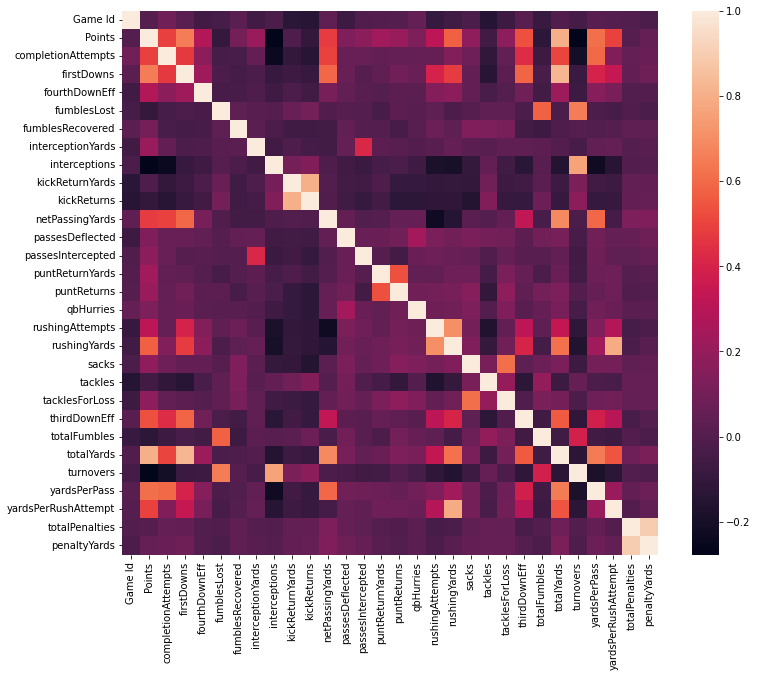

In [13]:
%matplotlib inline

corr = game_data_pivot.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr)
plt.show()

The only feature that is very highly correlated with Points is totalYards. This is expected, so we don't want to drop this feature, at least at this stage in our project.

## Visualization

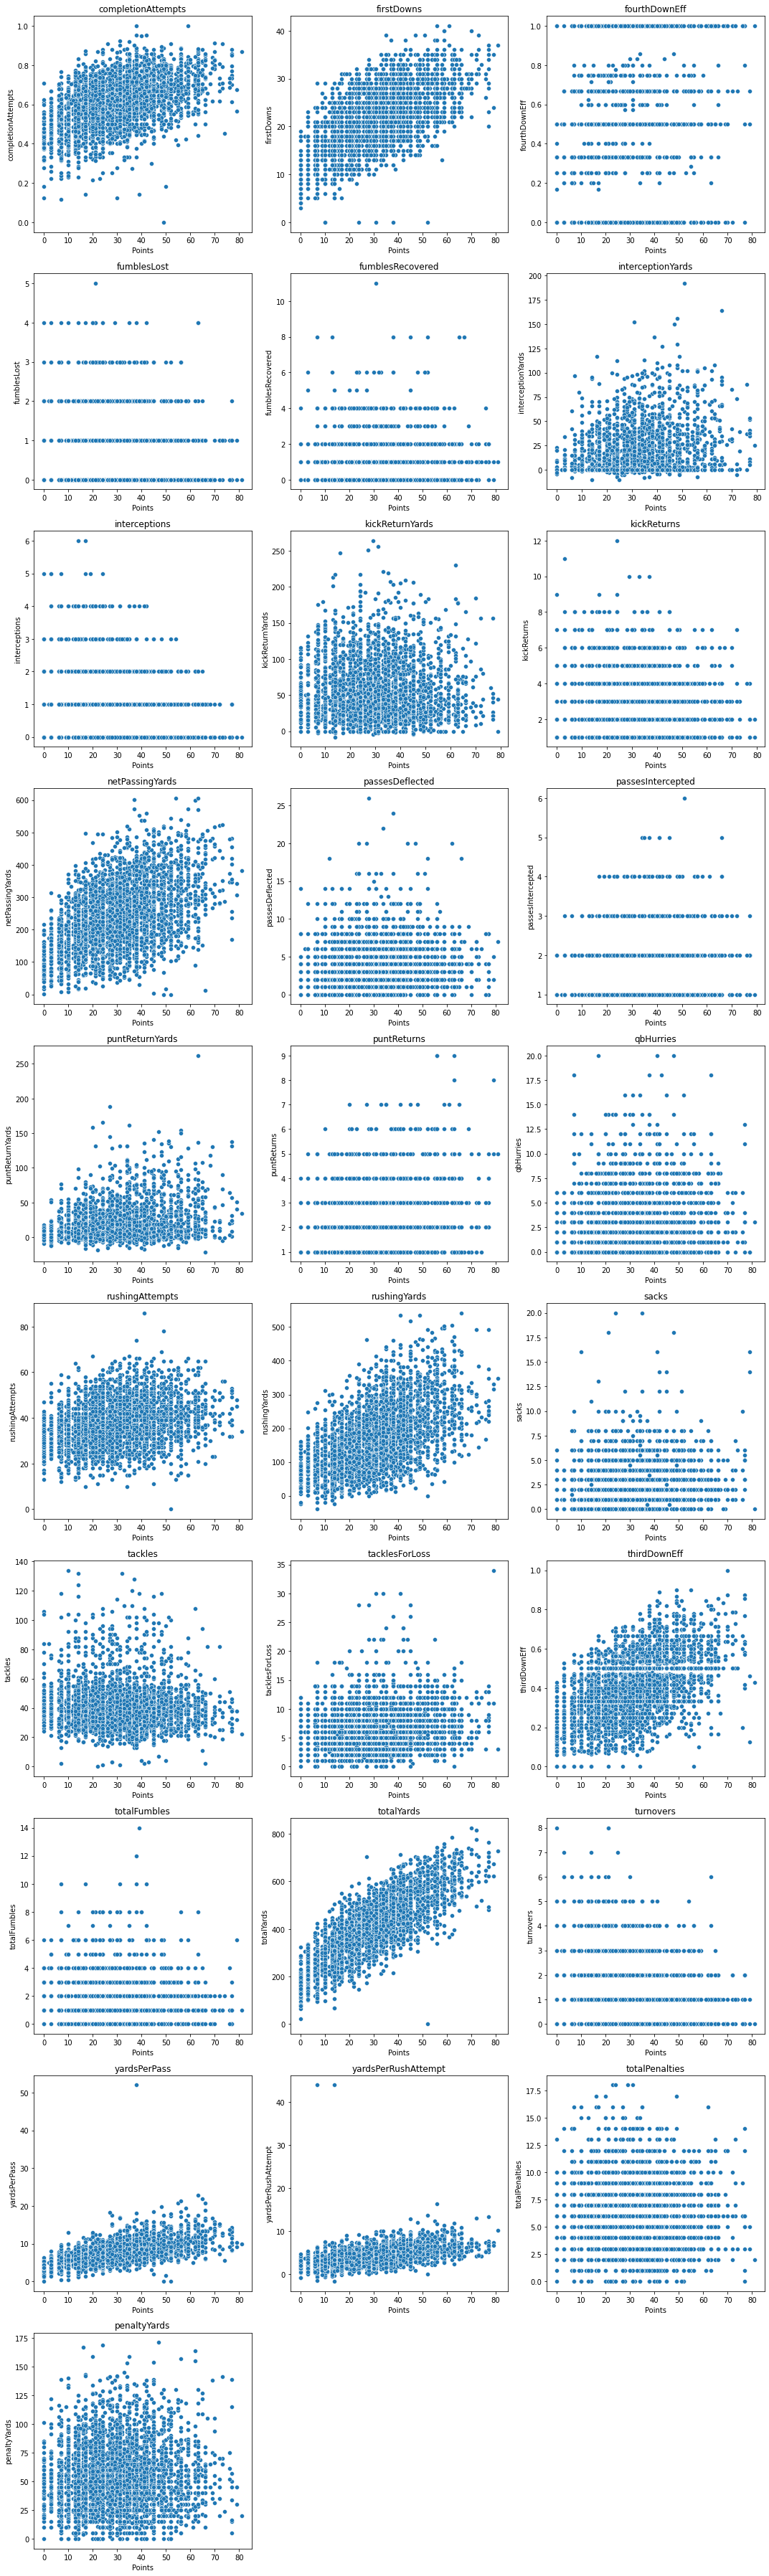

In [14]:
# Filter numeric columns (excluding 'Points')
numeric_features = game_data_pivot.select_dtypes(include=['number']).drop(columns=['Points', 'Game Id']).columns

n_features = len(numeric_features)
n_cols = 3
n_rows = n_features // n_cols + (n_features % n_cols > 0)

# Create a large figure
plt.figure(figsize=(15, 5*n_rows))

for idx, feature in enumerate(numeric_features, 1):  # idx starts from 1 for subplot indexing
    plt.subplot(n_rows, n_cols, idx)
    sns.scatterplot(data=game_data_pivot, x='Points', y=feature)
    plt.title(feature)

plt.tight_layout()
plt.show()


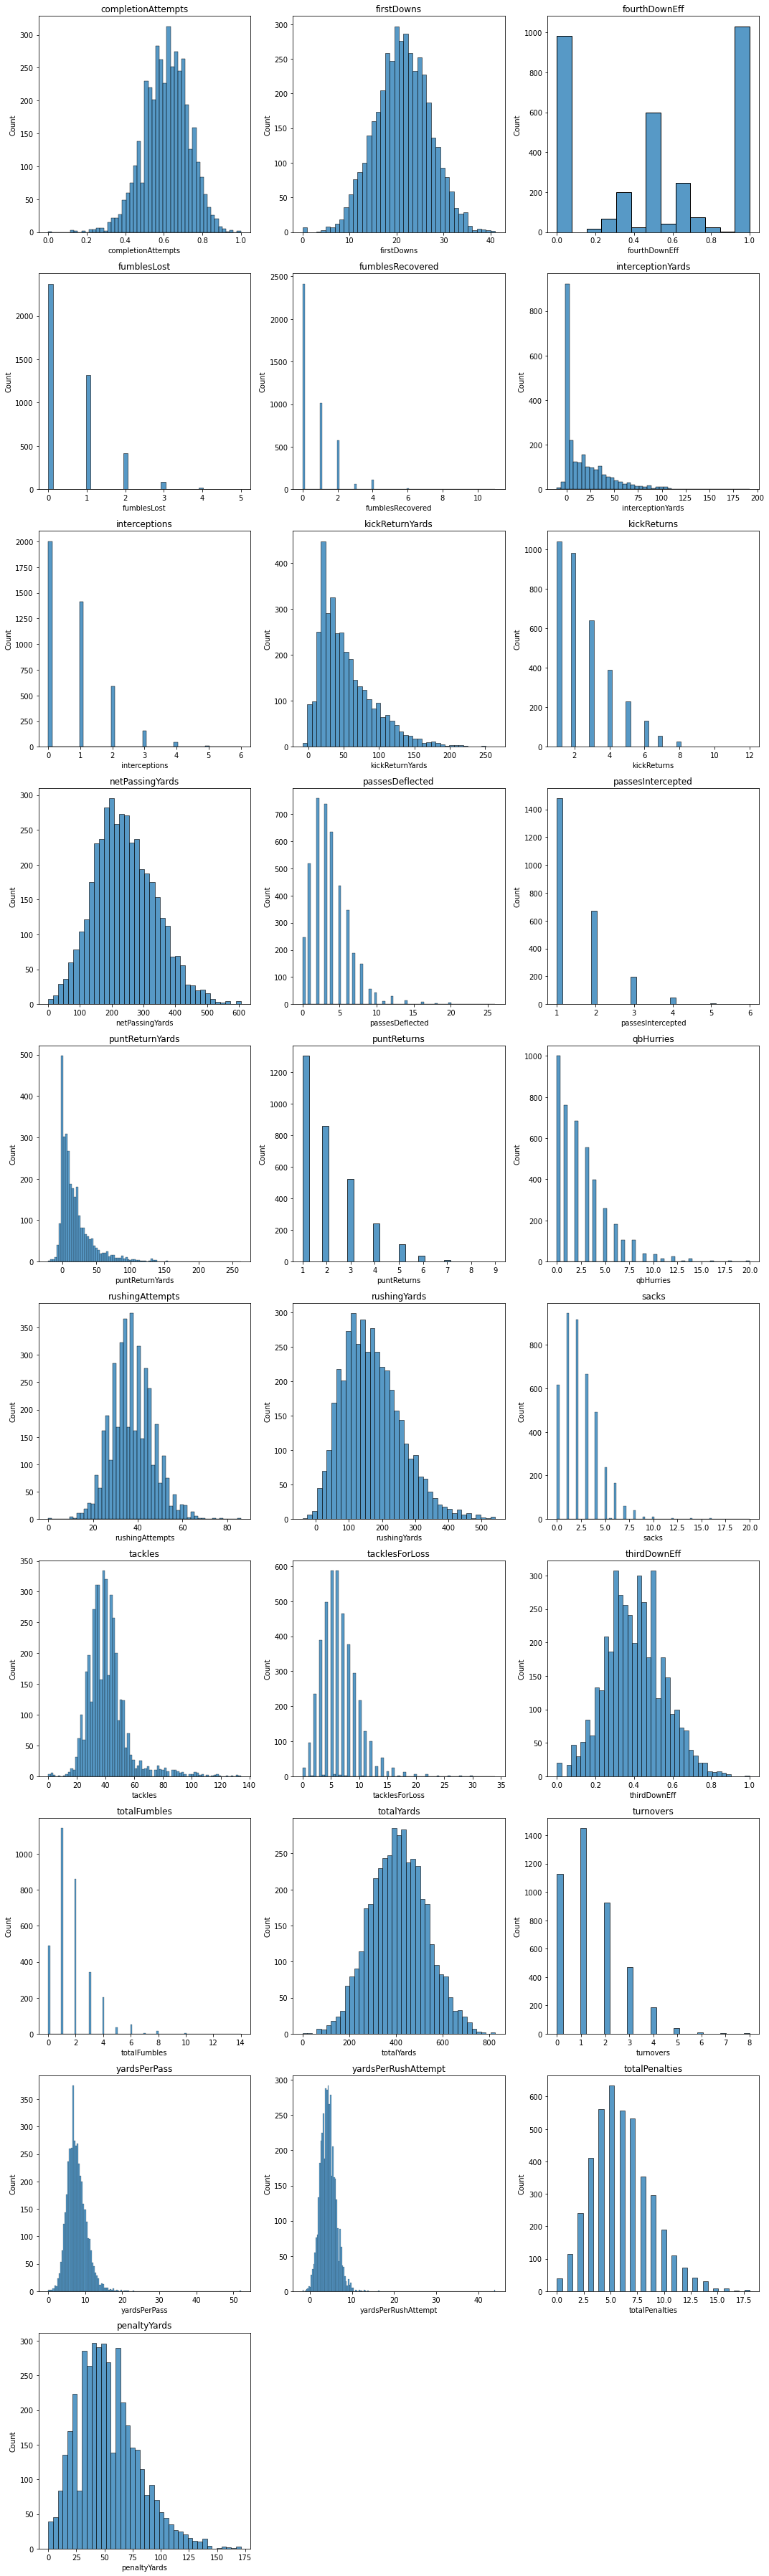

In [15]:
# Filter numeric columns (excluding 'Points')
numeric_features = game_data_pivot.select_dtypes(include=['number']).drop(columns=['Points', 'Game Id']).columns

n_features = len(numeric_features)
n_cols = 3
n_rows = n_features // n_cols + (n_features % n_cols > 0)

# Create a large figure
plt.figure(figsize=(15, 5*n_rows))

for idx, feature in enumerate(numeric_features, 1):  # idx starts from 1 for subplot indexing
    plt.subplot(n_rows, n_cols, idx)
    sns.histplot(data=game_data_pivot, x=feature)
    plt.title(feature)

plt.tight_layout()
plt.show()


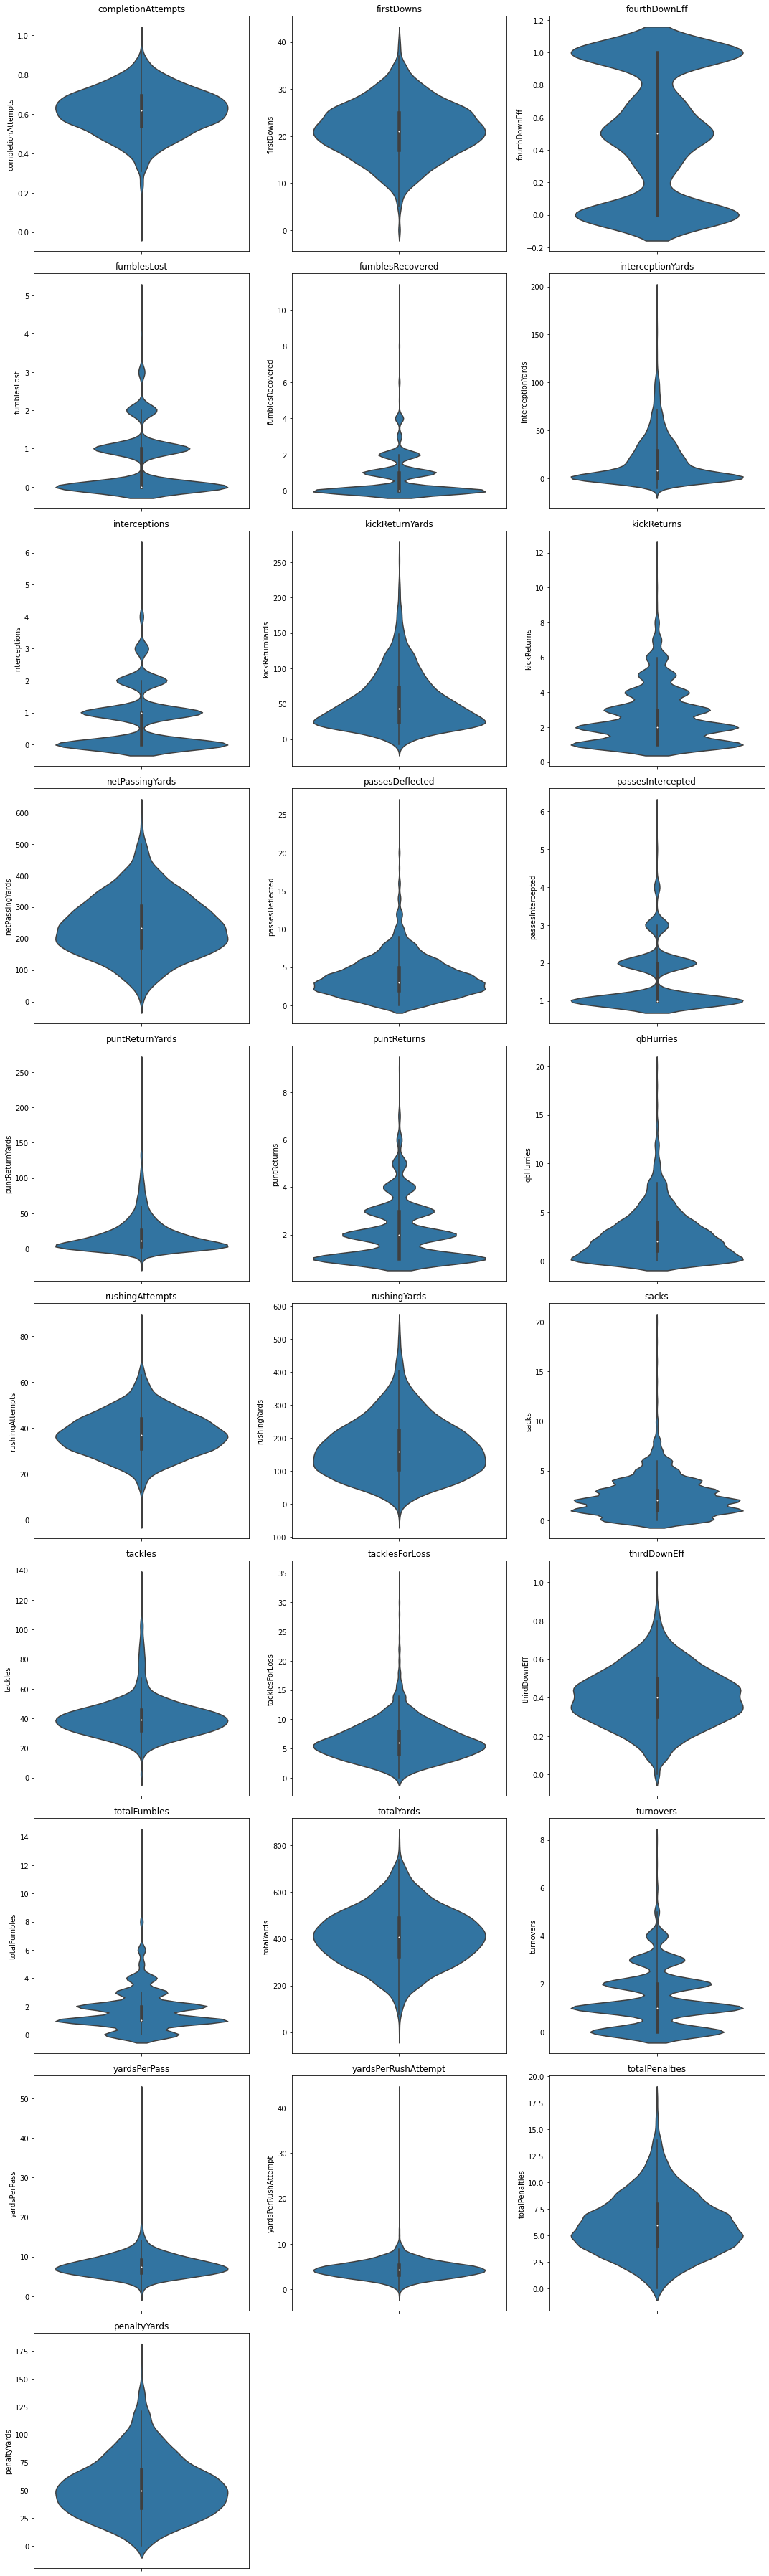

In [16]:
# Filter numeric columns (excluding 'Points')
numeric_features = game_data_pivot.select_dtypes(include=['number']).drop(columns=['Points', 'Game Id']).columns

n_features = len(numeric_features)
n_cols = 3
n_rows = n_features // n_cols + (n_features % n_cols > 0)

# Create a large figure
plt.figure(figsize=(15, 5*n_rows))

for idx, feature in enumerate(numeric_features, 1):  # idx starts from 1 for subplot indexing
    plt.subplot(n_rows, n_cols, idx)
    sns.violinplot(data=game_data_pivot, y=feature)
    plt.title(feature)

plt.tight_layout()
plt.show()